In [1]:
# pip install pandas numpy scikit-learn xgboost matplotlib

import os
os.environ["OMP_NUM_THREADS"] = "1"      # 對 OpenMP 生效
os.environ["MKL_NUM_THREADS"] = "1"      #（可選）對 MKL BLAS 生效
os.environ["OPENBLAS_NUM_THREADS"] = "1" #（可選）若用到 OpenBLAS

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.model_selection import ParameterSampler
import xgboost as xgb
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

np.random.seed(42)

In [2]:
# 專讀 /mnt/data/出國旅客按目的地統計.csv -> outbound_daily（日頻）
def load_outbound_daily_feature_from_tourism(path, daily_index, col_name="outbound_daily"):
    import pandas as pd, numpy as np
    # 讀檔
    for enc in ["utf-8", "utf-8-sig", "cp950", "big5"]:
        try:
            df = pd.read_csv(path, encoding=enc)
            break
        except Exception:
            df = None
    if df is None:
        raise RuntimeError(f"無法讀取檔案：{path}")

    # 必要欄
    need = ["年別","月份","小計"]
    miss = [c for c in need if c not in df.columns]
    if miss:
        raise ValueError(f"檔案缺少欄位：{miss}（需要 年別、月份、小計）")

    # 轉西元年（若是民國年 e.g., 111 → 2022）
    y = pd.to_numeric(df["年別"], errors="coerce")
    y = y.where(y >= 1911, y + 1911)

    m = pd.to_numeric(df["月份"], errors="coerce")

    # 月起始日期
    month_start = pd.to_datetime(dict(year=y, month=m, day=1), errors="coerce")

    # 每月總量（小計）
    total = pd.to_numeric(df["小計"], errors="coerce")
    monthly = pd.Series(total.values, index=month_start).groupby(level=0).sum().sort_index()

    # 月均分到日：每月總量 / 當月天數
    parts = []
    for ms, tot in monthly.items():
        month_end = (ms + pd.offsets.MonthEnd(1))
        days = pd.date_range(ms, month_end, freq="D")
        per_day = float(tot) / len(days) if len(days) else np.nan
        parts.append(pd.Series(per_day, index=days))
    daily_series = pd.concat(parts, axis=0).sort_index()

    # 對齊到 metro 的 daily.index，前後用 ffill/bfill 補齊
    out = pd.Series(index=daily_index, dtype=float)
    out.loc[daily_series.index] = daily_series.values
    out = out.ffill().bfill()

    return pd.DataFrame({col_name: out}, index=daily_index)


使用字型： Microsoft JhengHei


C:\Users\User\AppData\Local\Temp\ipykernel_32596\2365926264.py:49: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["time"] = pd.to_datetime(df["time"], errors="coerce", infer_datetime_format=True)


[Exogenous] 已載入外生特徵：['outbound_daily']
[KMeans] 與 松山機場 同群站點（移除自身）：['G大坪林', 'O景安', 'O頭前庄', '中原', '中和', '先嗇宮', '動物園', '十四張', '南港軟體園區', '大湖公園']...
[Donor 最終名單(初始)] 26 站；前 10：['G大坪林', 'O景安', 'O頭前庄', '中原', '中和', '先嗇宮', '動物園', '十四張', '南港軟體園區', '大湖公園']
[Search] tried 10/40; best score=337.6743 (rmse=337.6619)
[Search] tried 20/40; best score=330.4325 (rmse=330.4258)
[Search] tried 30/40; best score=330.4325 (rmse=330.4258)
[Search] tried 40/40; best score=330.4325 (rmse=330.4258)

Top-5 configs by composite score:
        score    val_rmse       HHI     N_eff  max_share  n_donors  \
0  330.432489  330.425779  0.134205  7.451286   0.264721        37   
1  330.442362  330.423119  0.384870  2.598277   0.482465        37   
2  337.674342  337.661871  0.249422  4.009275   0.366914        37   
3  344.827699  344.820504  0.143902  6.949167   0.286405        37   
4  349.704480  349.696453  0.160530  6.229358   0.284207        37   

   learning_rate  max_depth  subsample  colsample_bytree  
0      

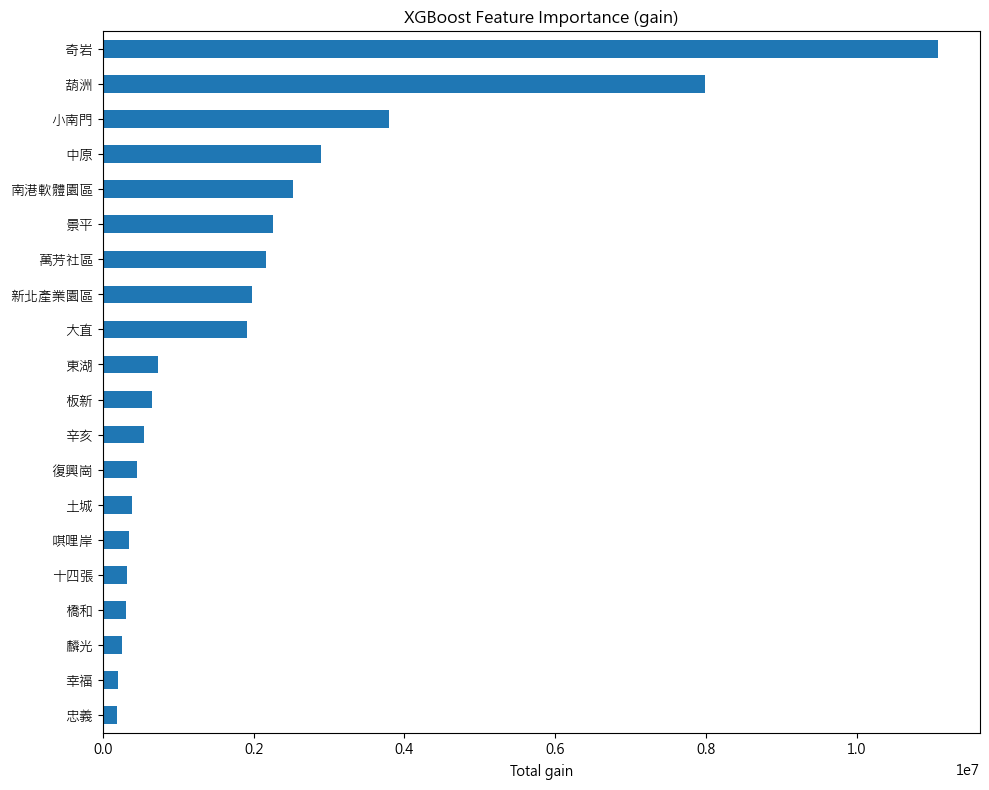


[Pre-Window Test (pre 90%~100%)]
  區間：2022-04-03 ~ 2022-05-08
  累積增量：9345
  平均每日增量：259.6
  相對合成對照：10.93%


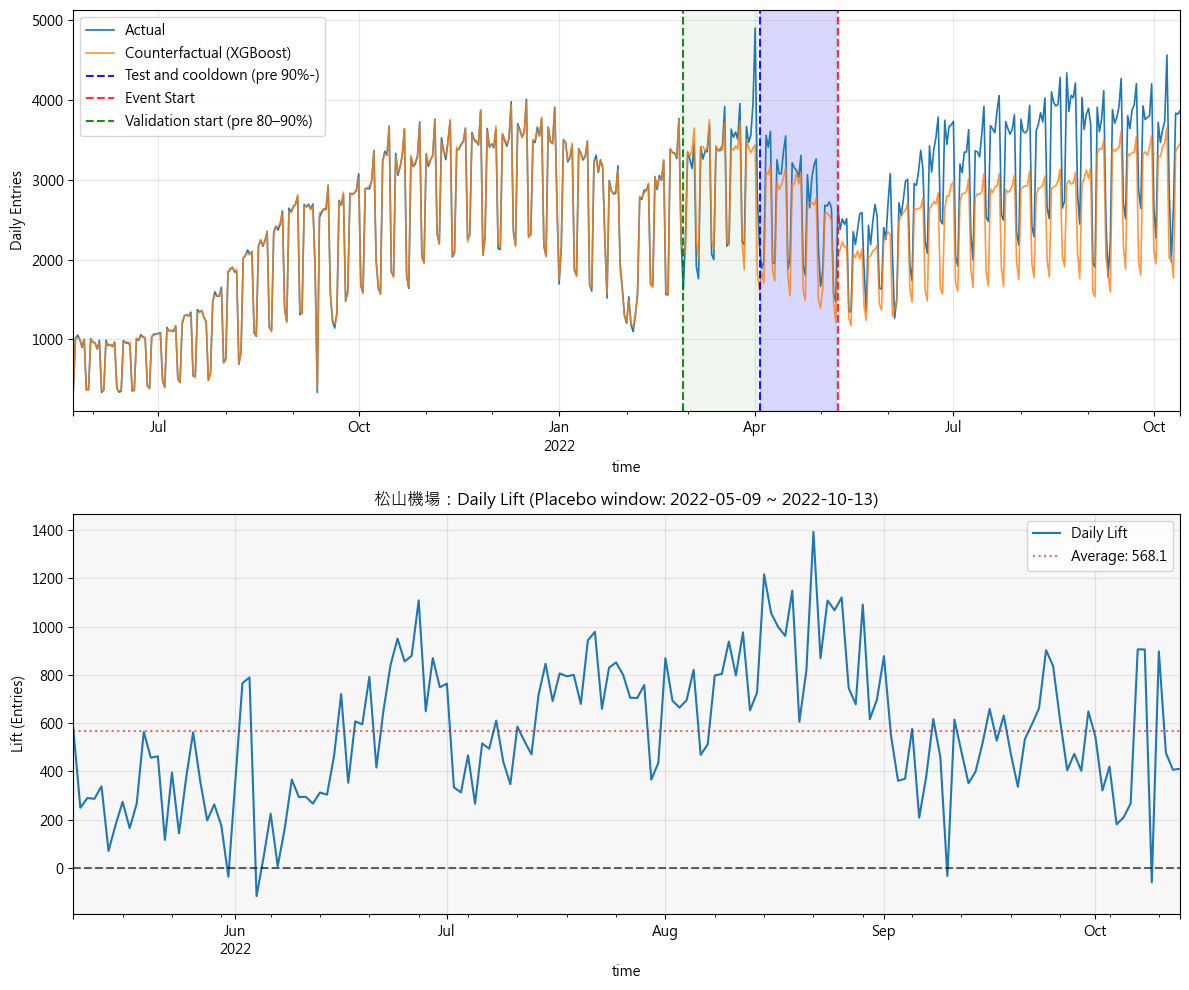


[額外統計]
  事件前平均（實際）：2330.4
  事件後平均（實際）：3095.6
  事件後平均（反事實）：2527.5
  提升比例：22.48%
RMSE(all): 149.921875 MAE(all): 61.726356506347656
RMSE(weekday): 141.43539428710938
RMSE(weekend): 169.10606384277344
週別平均殘差：
dow
0    36.062819
1    14.891727
2    26.847961
3    35.121473
4    68.798009
5    31.418924
6    31.480488
dtype: float64


C:\Users\User\AppData\Local\Temp\ipykernel_32596\2365926264.py:474: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print(diag.groupby("dow").apply(lambda g: float((g.y-g.yhat).mean())))


In [3]:

# -----------------------------
# 0) 路徑與事件設定
# -----------------------------
CSV = "../data/exits_by_station_hour.csv"  # 你的寬表：time + 各站欄位
OUTBOUND_CSV = "../data/出國旅客按目的地統計.csv"
TARGET = "松山機場"

'''
EVENT_START = pd.Timestamp("2022-05-09")  # 0+7 上路: 10/13, 7+7上路: 05/09
PRE_START   = pd.Timestamp("2021-05-28")  # pre 期
POST_END    = pd.Timestamp("2022-12-31")  # post 期（可調）
# Placebo 視窗（當作 post 期對照）
PLACEBO_START = pd.Timestamp("2022-05-09")
PLACEBO_END   = pd.Timestamp("2022-12-31")
'''

EVENT_START = pd.Timestamp("2022-05-09")  # 0+7 上路: 10/13, 7+7上路: 05/09
PRE_START   = pd.Timestamp("2021-05-23")  # pre 期
POST_END    = pd.Timestamp("2022-10-13")  # post 期（可調）
# Placebo 視窗（當作 post 期對照）
PLACEBO_START = pd.Timestamp("2022-05-09")
PLACEBO_END   = pd.Timestamp("2022-10-13")

N_CLUSTERS = 8        # 初始 KMeans 的 K（僅作參考；搜尋會覆蓋）
N_MIN_DONORS = 5      # 至少要有幾個 donor，不足就用相關性補

cjk_candidates = [
    "Microsoft JhengHei", "PingFang TC", "Noto Sans CJK TC", "Noto Sans CJK JP",
    "SimHei", "WenQuanYi Zen Hei", "PMingLiU", "MingLiU", "Heiti TC"
]
available = {f.name for f in fm.fontManager.ttflist}
pick = next((f for f in cjk_candidates if f in available), None)

if pick:
    matplotlib.rcParams["font.sans-serif"] = [pick]
    matplotlib.rcParams["font.family"] = "sans-serif"
matplotlib.rcParams["axes.unicode_minus"] = False  # 修正負號

print("使用字型：", pick or "系統預設（可能不支援中文）")

# -----------------------------
# 1) 載入與彙總：小時→日
# -----------------------------
def read_df(path):
    try:
        df = pd.read_csv(path, encoding="utf-8")
    except UnicodeDecodeError:
        df = pd.read_csv(path, encoding="utf-8-sig")
    df["time"] = pd.to_datetime(df["time"], errors="coerce", infer_datetime_format=True)
    df = df.dropna(subset=["time"]).set_index("time").sort_index()
    return df.fillna(0)

raw = read_df(CSV)
daily = raw.resample("D").sum()
assert TARGET in daily.columns, f"找不到欄位：{TARGET}"

# 載入外生變數: 
exo_all = load_outbound_daily_feature_from_tourism(OUTBOUND_CSV, daily.index, col_name="outbound_daily")
exo_cols = list(exo_all.columns)
print(f"[Exogenous] 已載入外生特徵：{exo_cols}")


# -----------------------------
# 2) 用 KMeans 分群挑 donor（只用 pre 期序列）
#    做法：pre 期日序列 → z-score → PCA(保留95%解釋力) → KMeans
#    （注意：第 5 段的搜尋會覆蓋這裡的 donors）
# -----------------------------
pre_mask = (daily.index >= PRE_START) & (daily.index < EVENT_START)
pre_mat = daily.loc[pre_mask]

Z = StandardScaler(with_mean=True, with_std=True).fit_transform(pre_mat.T)  # shape: stations × T_pre
pca = PCA(n_components=0.95, svd_solver="full", random_state=42)
Z_pca = pca.fit_transform(Z)

kmeans = KMeans(n_clusters=N_CLUSTERS, n_init="auto", random_state=42)
labels = kmeans.fit_predict(Z_pca)

cluster_of_target = labels[list(pre_mat.columns).index(TARGET)]
cluster_members = [c for c, lab in zip(pre_mat.columns, labels) if lab == cluster_of_target and c != TARGET]

# 候選 donor 不足就用「與 target 的 pre 期相關性」補滿
donors = cluster_members.copy()
if len(donors) < N_MIN_DONORS:
    corr = pre_mat.corr()[TARGET].drop(TARGET).abs().sort_values(ascending=False)
    for c in corr.index:
        if c not in donors:
            donors.append(c)
        if len(donors) >= max(N_MIN_DONORS, len(cluster_members) + 10):
            break

print(f"[KMeans] 與 {TARGET} 同群站點（移除自身）：{cluster_members[:10]}{'...' if len(cluster_members)>10 else ''}")
print(f"[Donor 最終名單(初始)] {len(donors)} 站；前 10：{donors[:10]}")

X_all = daily[donors].copy()
y_all = daily[TARGET].copy()

# -----------------------------
# 3) 建立日曆特徵
# -----------------------------
def calendar_features(idx: pd.DatetimeIndex) -> pd.DataFrame:
    dfc = pd.DataFrame(index=idx)
    dfc["dow"] = idx.dayofweek
    dfc["doy"] = idx.dayofyear
    dfc["is_weekend"] = (dfc["dow"] >= 5).astype(int)
    dfc["dow_sin"] = np.sin(2*np.pi*dfc["dow"]/7)
    dfc["dow_cos"] = np.cos(2*np.pi*dfc["dow"]/7)
    dfc["doy_sin"] = np.sin(2*np.pi*dfc["doy"]/365.25)
    dfc["doy_cos"] = np.cos(2*np.pi*dfc["doy"]/365.25)
    dummies = pd.get_dummies(dfc["dow"], prefix="dow", drop_first=True)
    return pd.concat([dfc[["dow_sin","dow_cos","doy_sin","doy_cos"]], dummies], axis=1)

cal_all = calendar_features(daily.index)

# -----------------------------
# 4) 組合訓練資料：X = donors + calendar；Y = TARGET
#    全程只用 pre 期訓練；pre 末尾切一段做 time-based 驗證
# -----------------------------
X = pd.concat([X_all, cal_all], axis=1)
y = y_all

pre_mask  = (X.index >= PRE_START)  & (X.index < EVENT_START)
pre_X, pre_y = X.loc[pre_mask], y.loc[pre_mask]
N = len(pre_X)
i70, i80, i90 = int(N*0.7), int(N*0.8), int(N*0.9)

idx_train = pre_X.index[:i80]
idx_valid = pre_X.index[i80:i90]
# Test：pre 的最後 10%
idx_test  = pre_X.index[i90:]
# Cooldown 改到 post 才定義（事件後前 14 天），此處先不設 idx_cool

# 給 XGBoost 用的 train/valid
X_tr, y_tr = pre_X.loc[idx_train], pre_y.loc[idx_train]
X_va, y_va = pre_X.loc[idx_valid], pre_y.loc[idx_valid]

# -----------------------------
# 5) Hyperparameter search (PCA + KMeans + XGBoost)
# -----------------------------
def pick_donors(pre_mat: pd.DataFrame, target: str, n_clusters: int, pca_var: float, n_min_donors: int):
    """根據 PCA(保留率) + KMeans(群數) 在 pre 期挑 donors；不足時用與 target 的相關性補齊"""
    Z = StandardScaler(with_mean=True, with_std=True).fit_transform(pre_mat.T)  # stations × T_pre
    pca = PCA(n_components=pca_var, svd_solver="full", random_state=42)
    Z_pca = pca.fit_transform(Z)
    km = KMeans(n_clusters=n_clusters, n_init="auto", random_state=42)
    labels = km.fit_predict(Z_pca)

    target_idx = list(pre_mat.columns).index(target)
    cluster_of_target = labels[target_idx]
    cluster_members = [c for c, lab in zip(pre_mat.columns, labels) if lab == cluster_of_target and c != target]

    donors = cluster_members.copy()
    if len(donors) < n_min_donors:
        corr = pre_mat.corr()[target].drop(target).abs().sort_values(ascending=False)
        for c in corr.index:
            if c not in donors:
                donors.append(c)
            if len(donors) >= max(n_min_donors, len(cluster_members) + 10):
                break
    return donors


best_model = None
best_cfg   = None
best_rmse  = float("inf")
best_score = float("inf")   # ← 新增：複合評分的最佳值

def donor_concentration_from_gain(model, X_columns, donor_cols):
    """
    從 XGBoost 的 'gain' 推 donor 重要度分佈，回傳 HHI / N_eff / max_share。
    兼容 f0,f1,... 與真實欄名兩種情況；donor 沒被用到時給均勻分布以避免除零。
    """
    booster = model.get_booster()
    fscore = booster.get_score(importance_type="gain")  # 可能是 {'f0':..., 'f1':...} 或 {'站A':..., 'dow_sin':...}
    if not fscore:
        # 極少數情況下 model 沒留下重要度；全部均分
        p = np.ones(len(donor_cols)) / max(1, len(donor_cols))
        hhi = float((p**2).sum())
        return {"HHI": hhi, "N_eff": float(1/hhi), "max_share": float(p.max()), "p": dict(zip(donor_cols, p))}

    keys = list(fscore.keys())
    # 判斷是 f0/f1 還是實際欄名
    if all(isinstance(k, str) and k.startswith("f") and k[1:].isdigit() for k in keys):
        # 用欄位順序把 f{i} 映回真實欄名
        idx_map = {f"f{i}": col for i, col in enumerate(list(X_columns))}
        gain_named = {idx_map[k]: v for k, v in fscore.items() if k in idx_map}
    else:
        gain_named = fscore  # 已是實際欄名

    g = np.array([float(gain_named.get(c, 0.0)) for c in donor_cols], dtype=float)
    if g.sum() <= 0:
        p = np.ones(len(donor_cols)) / max(1, len(donor_cols))
    else:
        p = g / g.sum()
    hhi = float((p**2).sum())
    return {"HHI": hhi, "N_eff": float(1/hhi), "max_share": float(p.max()), "p": dict(zip(donor_cols, p))}

search_space = {
    "pca_var":           [0.90, 0.95, 0.99],
    "n_clusters":        [6, 8, 10, 12],
    "learning_rate":     [0.02, 0.05, 0.10],
    "max_depth":         [3, 4, 5, 6],
    "min_child_weight":  [3, 5, 10],
    "subsample":         [0.7, 0.85, 1.0],
    "colsample_bytree":  [0.7, 0.85, 1.0],
    "gamma":             [5, 10, 50, 100],
    "reg_alpha":         [1, 10, 100],
    "reg_lambda":        [0.1, 1, 5, 10],
}
n_iter = 40  # 可調；越大越慢
param_list = list(ParameterSampler(search_space, n_iter=n_iter, random_state=42))

results = []
best_model = None
best_cfg = None
best_rmse = float("inf")

for i, p in enumerate(param_list, 1):
    donors_try = pick_donors(pre_mat, TARGET, p["n_clusters"], p["pca_var"], N_MIN_DONORS)

    X_try_all = daily[donors_try].copy()
    X_try = pd.concat([X_try_all, cal_all, exo_all], axis=1)  # ← 保持有外生變數
    pre_X_try = X_try.loc[pre_mask]

    split_try = int(len(pre_X_try) * 0.8)
    X_tr, X_va = pre_X_try.iloc[:split_try], pre_X_try.iloc[split_try:]
    y_tr, y_va = pre_y.iloc[:split_try], pre_y.iloc[split_try:]

    model = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=5000,
        learning_rate=p["learning_rate"],
        max_depth=p["max_depth"],
        min_child_weight=p["min_child_weight"],
        subsample=p["subsample"],
        colsample_bytree=p["colsample_bytree"],
        gamma=p["gamma"],
        reg_alpha=p["reg_alpha"],
        reg_lambda=p["reg_lambda"],
        eval_metric="rmse",
        early_stopping_rounds=100,
        random_state=42,
        tree_method="hist",
        verbosity=0,
    )

    model.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        
        
        verbose=False
    )

    pred_va = model.predict(X_va)
    val_rmse = float(np.sqrt(mean_squared_error(y_va, pred_va)))

    cm = donor_concentration_from_gain(model, X_try.columns, donors_try)

    lam = 0.05  # 你可以調整；視資料尺度調 0.01~0.2
    score = val_rmse + lam * cm["HHI"]

    # 記錄結果（把指標放進去，方便之後排序/檢視）
    results.append({
        **p,
        "n_donors": len(donors_try),
        "val_rmse": val_rmse,
        "HHI": cm["HHI"],
        "N_eff": cm["N_eff"],
        "max_share": cm["max_share"],
        "score": score,
        "best_iteration": getattr(model, "best_iteration", None),
    })

    # 用複合評分挑最佳；若分數打平，用較小的 RMSE 當 tie-breaker
    if (score < best_score) or (np.isclose(score, best_score) and val_rmse < best_rmse):
        best_score = score
        best_rmse  = val_rmse
        best_model = model
        best_cfg   = {**p, "donors": donors_try}

    # （選擇性）每 10 次印一下目前最佳
    if i % 10 == 0:
        print(f"[Search] tried {i}/{len(param_list)}; best score={best_score:.4f} (rmse={best_rmse:.4f})")

res_df = pd.DataFrame(results).sort_values(["score","val_rmse"]).reset_index(drop=True)
print("\nTop-5 configs by composite score:")
print(res_df.head(5)[["score","val_rmse","HHI","N_eff","max_share","n_donors","learning_rate","max_depth","subsample","colsample_bytree"]])


donors = best_cfg["donors"]
print(f"\n[Best donors] {len(donors)}：{donors[:10]}{'...' if len(donors) > 10 else ''}")
print(f"[Best XGB cfg] { {k: best_cfg[k] for k in best_cfg if k!='donors'} }")
print(f"[Best valid RMSE] {best_rmse:.2f}")
print(f"[Best iteration] {getattr(best_model, 'best_iteration', None)}")

# 用最佳 donors + 模型重建全資料特徵
X_all = daily[donors].copy()
X = pd.concat([X_all, cal_all, exo_all], axis=1)
y = y_all

# 以 X.index 重新定義切割遮罩，避免長度不一致
pre_mask  = (X.index >= PRE_START)  & (X.index < EVENT_START)
post_mask = (X.index >= EVENT_START) & (X.index <= POST_END)
pre_X, post_X = X.loc[pre_mask], X.loc[post_mask]
model = best_model


# =============================
# 5.1) Feature Importance (XGBoost)
#  放在：model = best_model 之後，pred_pre_full 之前
# =============================
booster = model.get_booster()
# 盡量用 booster 的名稱；沒拿到就用 DataFrame 欄名
feature_names = getattr(booster, "feature_names", None) or list(X.columns)

def _to_named_series(score_dict, feature_names):
    s = pd.Series(score_dict, dtype=float)
    # 若 key 長得像 f0,f1,... → 轉成實際欄名
    if not s.empty and all(isinstance(k, str) and k.startswith("f") and k[1:].isdigit() for k in s.index):
        try:
            s.index = [feature_names[int(k[1:])] for k in s.index]
        except Exception:
            pass
    # 補齊沒有出現的特徵（分數=0）
    return s.reindex(feature_names, fill_value=0.0)

imp_types = ["gain", "weight", "cover", "total_gain", "total_cover"]
imp_df = pd.DataFrame({
    t: _to_named_series(booster.get_score(importance_type=t), feature_names)
    for t in imp_types
})
imp_df["gain_pct"] = imp_df["gain"] / (imp_df["gain"].sum() or 1.0)
imp_df = imp_df.sort_values("gain", ascending=False)

print("\n[Feature importance — top 20 by GAIN]")
print(imp_df.head(20).round(4))

# 群組檢視：Donor vs. Calendar
donor_cols = list(daily[donors].columns)
cal_cols = [c for c in X.columns if c not in donor_cols]
group_view = pd.DataFrame({
    "group": ["donor" if c in donor_cols else "calendar" for c in imp_df.index],
    "gain": imp_df["gain"].values
}).groupby("group")["gain"].sum().sort_values(ascending=False)
print("\n[Group importance by GAIN]")
print(group_view)

# 存檔
imp_df.to_csv("xgb_feature_importance.csv", encoding="utf-8-sig")
print("已輸出：xgb_feature_importance.csv")

# 繪圖（前 20）
topk = 20
ax = imp_df.head(topk)["gain"].plot(kind="barh", figsize=(10, 8), title="XGBoost Feature Importance (gain)")
ax.invert_yaxis()
ax.set_xlabel("Total gain")
plt.tight_layout()
plt.show()

# -----------------------------
# 6) 產生 counterfactual 與 lift 分析（沿用你的流程）
# -----------------------------
pred_pre_full = model.predict(pre_X)
pred_post = model.predict(post_X)

cf_series = pd.concat([
    pd.Series(pred_pre_full, index=pre_X.index),
    pd.Series(pred_post, index=post_X.index)
]).rename("counterfactual")

actual_series = y.loc[cf_series.index]

test_actual = actual_series.loc[idx_test]
test_cf     = cf_series.loc[idx_test]

test_lift = (test_actual - test_cf)


print("\n[Pre-Window Test (pre 90%~100%)]")
print(f"  區間：{idx_test[0].date()} ~ {idx_test[-1].date()}")
print(f"  累積增量：{int(test_lift.sum())}")
print(f"  平均每日增量：{test_lift.mean():.1f}")
print(f"  相對合成對照：{(test_lift.sum()/max(1.0, test_cf.sum()))*100:.2f}%")


# -----------------------------
# 7) 視覺化
# -----------------------------
# 計算 validation 開始的日期（pre 期最後 20% 的第一天）


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

actual_series.plot(ax=ax1, label="Actual", linewidth=1.2)



placebo_mask   = (actual_series.index >= PLACEBO_START) & (actual_series.index <= PLACEBO_END)
placebo_actual = actual_series.loc[placebo_mask]
placebo_cf     = cf_series.loc[placebo_mask]
placebo_lift   = placebo_actual - placebo_cf

# 在組好 actual_series / cf_series 之後，用它們的 index 重新建遮罩
post_mask_local = (actual_series.index >= EVENT_START) & (actual_series.index <= POST_END)
pre_mask_local  = (actual_series.index >= PRE_START)   & (actual_series.index <  EVENT_START)

post_actual = actual_series.loc[post_mask_local]
post_cf     = cf_series.loc[post_mask_local]

pre_actual  = actual_series.loc[pre_mask_local]
pre_cf      = cf_series.loc[pre_mask_local]


cf_series.plot(ax=ax1, label="Counterfactual (XGBoost)", linewidth=1.2, alpha=0.8)

# Test：pre 的最後 10%
ax1.axvline(idx_test[0], linestyle="--", alpha=0.9, color="blue",  label="Test and cooldown (pre 90%-)")
ax1.axvspan(idx_test[0], idx_test[-1], color="blue", alpha=0.08)


# 事件線
ax1.axvline(EVENT_START, linestyle="--", alpha=0.8, color='red', label="Event Start")

# 可選：加陰影更清楚
ax1.axvspan(idx_test[0], idx_test[-1], color="blue", alpha=0.08)


ax1.axvline(idx_valid[0], linestyle="--", alpha=0.9, color="green", label="Validation start (pre 80–90%)")
ax1.axvspan(idx_valid[0], idx_valid[-1], color="green", alpha=0.06)

ax2.set_title(f"{TARGET}：Daily Lift (Placebo window: {PLACEBO_START.date()} ~ {PLACEBO_END.date()})")
ax1.set_ylabel("Daily Entries")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.clear()
placebo_lift.plot(
    ax=ax2,
    label="Daily Lift",
    title=f"{TARGET}：Daily Lift (Post: 2021-05-28 ~ 2022-02-28)"
)
ax2.axvspan(PLACEBO_START, PLACEBO_END, color="gray", alpha=0.06)
ax2.axhline(0, linestyle="--", alpha=0.6, color='black')
ax2.axhline(placebo_lift.mean(), linestyle=":", alpha=0.6, color='red',
            label=f"Average: {placebo_lift.mean():.1f}")
ax2.set_ylabel("Lift (Entries)")
ax2.set_title(f"{TARGET}：Daily Lift (Placebo window: {PLACEBO_START.date()} ~ {PLACEBO_END.date()})")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 額外統計
print("\n[額外統計]")
print(f"  事件前平均（實際）：{actual_series.loc[pre_X.index].mean():.1f}")
print(f"  事件後平均（實際）：{post_actual.mean():.1f}")
print(f"  事件後平均（反事實）：{post_cf.mean():.1f}")
print(f"  提升比例：{(post_actual.mean() / post_cf.mean() - 1) * 100:.2f}%")

def rmse(a,b):
    try: return root_mean_squared_error(a,b)
    except TypeError: return float(np.sqrt(mean_squared_error(a,b)))

pre_actual = actual_series.loc[:EVENT_START-pd.Timedelta(days=1)]
pre_cf     = cf_series.loc[pre_actual.index]
diag = pd.DataFrame({"y":pre_actual, "yhat":pre_cf}, index=pre_actual.index)
diag["dow"] = diag.index.dayofweek
diag["is_weekend"] = (diag["dow"]>=5).astype(int)
print("RMSE(all):", rmse(diag.y, diag.yhat), "MAE(all):", mean_absolute_error(diag.y, diag.yhat))
print("RMSE(weekday):", rmse(diag.loc[diag.is_weekend==0,"y"], diag.loc[diag.is_weekend==0,"yhat"]))
print("RMSE(weekend):", rmse(diag.loc[diag.is_weekend==1,"y"], diag.loc[diag.is_weekend==1,"yhat"]))
print("週別平均殘差：")
print(diag.groupby("dow").apply(lambda g: float((g.y-g.yhat).mean())))


In [4]:
def block_bootstrap_ci_by_index(actual, cf, pre_idx, post_idx, block=7, B=2000, seed=42):
    """
    actual, cf: 兩個同 index 的 Series（只含你要分析的區間亦可）
    pre_idx, post_idx: 直接傳 DatetimeIndex（例如 pre_X.index, post_X.index）
    """
    assert actual.index.equals(cf.index)

    # pre 期殘差
    resid_pre = (actual.loc[pre_idx] - cf.loc[pre_idx]).to_numpy()
    T_post = len(post_idx)

    # 防呆：block 不可大於可用長度
    if len(resid_pre) == 0:
        raise ValueError("pre period residuals is empty.")
    block = max(1, min(block, len(resid_pre)))

    # 建 blocks
    blocks = [resid_pre[i:i+block] for i in range(0, len(resid_pre)-block+1)]
    if not blocks:
        blocks = [resid_pre]  # pre 太短時退而求其次

    rng = np.random.default_rng(seed)
    ypost  = actual.loc[post_idx].to_numpy()
    cfpost = cf.loc[post_idx].to_numpy()

    cum_lifts = []
    for _ in range(B):
        path = []
        while len(path) < T_post:
            path.extend(blocks[rng.integers(0, len(blocks))])
        path = np.asarray(path[:T_post])
        cum_lifts.append((ypost - (cfpost + path)).sum())

    lo, hi = np.percentile(cum_lifts, [2.5, 97.5])
    return float(lo), float(hi)

# 用索引而非布林遮罩
lo, hi = block_bootstrap_ci_by_index(actual_series, cf_series, pre_idx=pre_X.index, post_idx=post_X.index, block=7, B=2000)
print(f"累積 Lift 95% CI: [{lo:,.0f}, {hi:,.0f}]")

累積 Lift 95% CI: [76,330, 90,628]
